In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

In [2]:
dt = pd.read_csv ("candump-2017-06-20_022638" , sep = " " , names = ['a' , 'b' , 'c']).iloc[:10000,:]

In [125]:
# Cleaning the data

data = dt

data['id'] = data['b']
data['data'] = data['b']
data['time'] = data['b']

for i in range ( len (data) ):
    data['id'][i] = data['c'][i][:3]
    data['data'][i] = int ( data['c'][i][4:] , 16)
    data['time'][i] = float ( data['a'][i][1:-1]) - 1497925598.604522

dataNew = data[['id' , 'time' , 'data']]

In [139]:
def arrayid (myid):
    df = []
    for i in range ( len (dataNew) ):
        if dataNew.id [i] == myid :
            df.append ( [ dataNew.time [i] , dataNew.data [i] ])  
    return np.array(df)
    
ids = np.unique( dataNew.id )

mdict = {}
for i in ids :
    x = arrayid(i)
    m = np.mean (x[:,1])
    s = np.std (x[:,1])
    if s/m  > 0.01 :
        mdict[i] = x
        
print ("The number of uniques in ids are " + str (len(ids)) )
print ("But there are just " + str(len(mdict)) + " with varying data.")


/home/saeed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


The number of uniques in ids are 192
But there are just 45 with varying data.


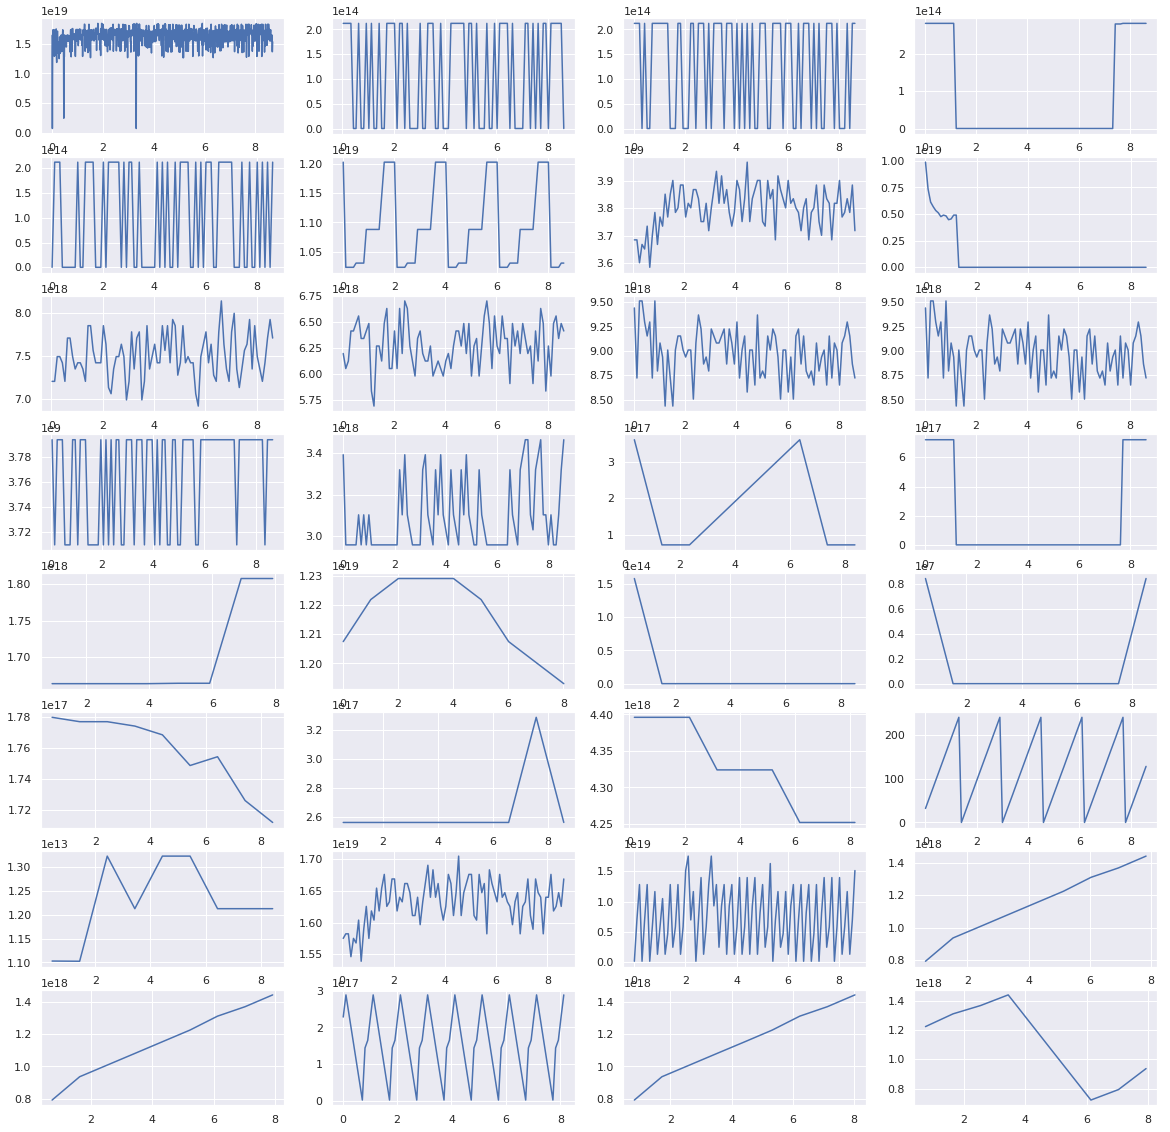

In [146]:
n=2
fig, ax = plt.subplots(nrows=4*n , ncols=4 , figsize=(20,10*n))

keys = list(mdict.keys())
marrays = list(mdict.values())

n = len(mdict)

i=0
for row in ax:
    for col in row:
        dfnp = marrays[i]
        col.plot ( dfnp[:,0] , dfnp[:,1])
        i = min(i +1 , n - 1)
#plt.show()
plt.savefig('datas_read.jpg')


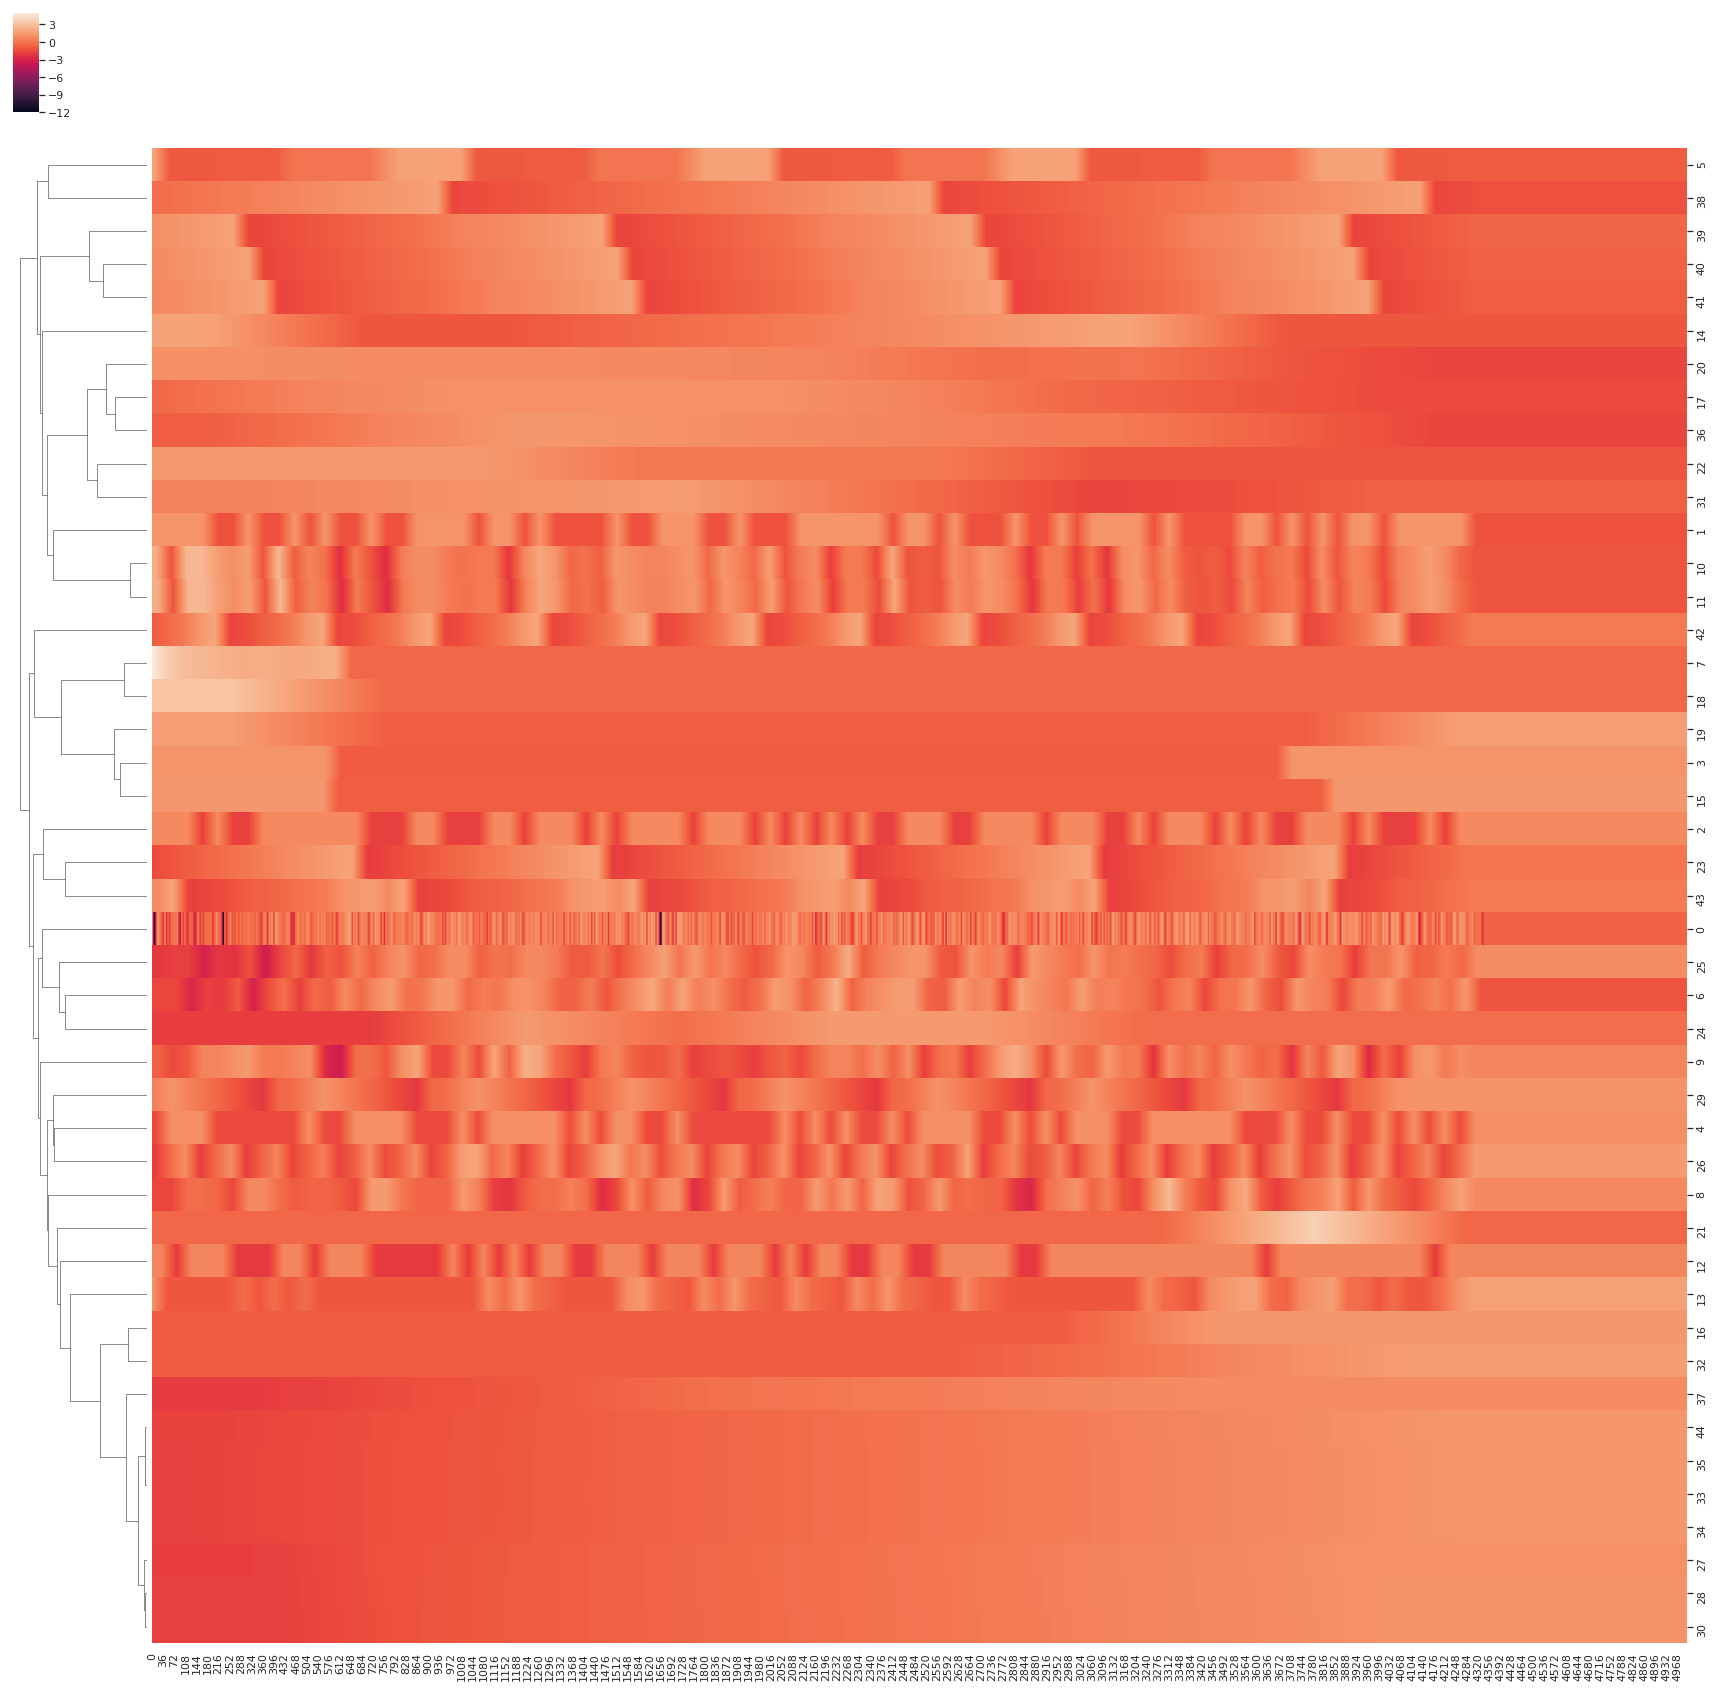

In [148]:
nsignals = len(mdict)
new_times = np.linspace(0, 10, 5000)

signals = np.empty((nsignals, 5000))
for isignal, signal in enumerate(mdict.values()):
    signals[isignal] = np.interp(new_times, signal[:, 0], signal[:, 1])
    
signals = (signals - signals.mean(axis=1)[:, None])/(signals.std(axis=1)[:, None]  + 1e-10)
# plt.figure(figsize=(20, 20))
# plt.imshow(signals, aspect='auto')

import seaborn as sns; sns.set(color_codes=True)
g = sns.clustermap(signals, col_cluster=False, figsize=(30, 30))

plt.savefig('clustering.jpg')